In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.labelsize": 18,
                    "axes.titlesize":18})
# Dictionary to map color strings to data sets
colors = {
    'ES':"tab:blue", 
    'ENGB':"tab:orange", 
    'DE':"tab:green", 
    'FR':"tab:red", 
    'PTBR':"tab:purple", 
    'RU':"tab:brown", 
    'chameleon':"tab:cyan", 
    'crocodile':"tab:gray",
    'squirrel':"tab:olive",
    "CA-GrQc":"maroon",
    "CA-AstroPh":"midnightblue"
}

# Create the path to output the final graphs to
GRAPH_OUT_PATH = os.path.join(os.getcwd(),"graphs")

In [219]:
# Open the results file
df = pd.read_csv("results.csv")

# Remove the file path from the dataset column, leaving us only with the dataset name
df["ds_path"] = df["ds_path"].apply(lambda x: x.split("/")[-1].split("_")[1] if ".csv" in x else x.split("/")[-1].split(".")[0])

# Create a mask to remove spectral
remove_spectral_mask = df.alg_name != "SpectralCount"

# Because SpectralCount calculates the EXACT number of triangles, it is the ground truth. 
correct = df[df.alg_name == "SpectralCount"].groupby(["ds_path"])[["runtime","result"]].max().reset_index()
 
# Calculate the PCT Speedup and the runtime for each one.
abs_errors = []
pct_speedups=[]
for i, r in df.iterrows():
        
    # Get the correct values for this dataset
    correct_for_ds = correct[correct["ds_path"] == r["ds_path"]]
    
    # 
    correct_result = correct_for_ds["result"].values[0]
    correct_runtime = correct_for_ds["runtime"].values[0]
    abs_errors.append(100*np.abs(correct_result- r["result"])/correct_result)
    pct_speedups.append(100*(correct_runtime-r["runtime"])/correct_runtime)
#     break
df["abs_error"] = abs_errors
df["pct_speedup"]=pct_speedups
# Groupby the alg_name and the ds name. Then select only runtime and result and get the mean for them. 
grouped_alg = df.groupby(["alg_name", "ds_path"])[["runtime", "result","abs_error","pct_speedup"]].mean().reset_index()


#### Graphing Runtime vs Data Setremove_spectral_mask

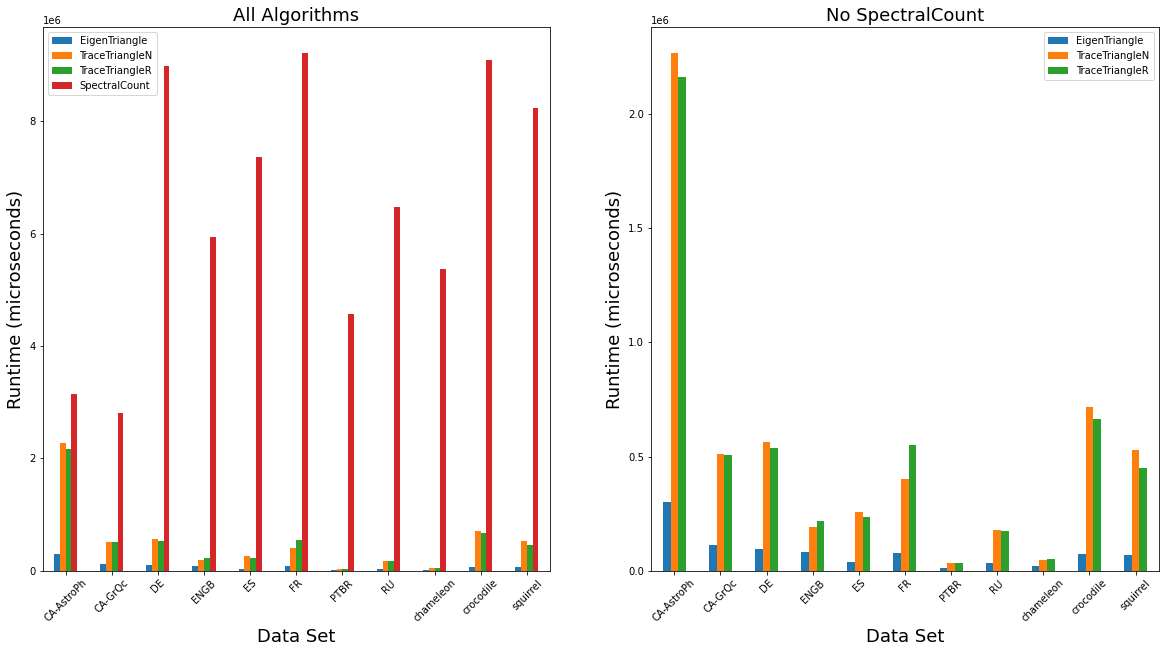

In [220]:
# Create the plots and axis
fig, ax = plt.subplots(1,2, figsize=(20, 10))

# Pivot creates a table with only a single value so that we can graph it
# [["EigenTriangle","TraceTriangleN","TraceTriangleR","SpectralCount"]] allows us to set the order of it. Useful for coloring in the second plot
grouped_alg.pivot("ds_path", "alg_name", "runtime")[["EigenTriangle","TraceTriangleN","TraceTriangleR","SpectralCount"]].plot(kind="bar", ax=ax[0], rot=45,sort_columns=False)

# Set the axis labels and graph it.
ax[0].set_ylabel("Runtime (microseconds)")
ax[0].set_xlabel("Data Set")
ax[0].legend(loc="best")
ax[0].set_title("All Algorithms")

# Create the graphe WITHOUT spectral count
# Pivot creates a table with only a single value so that we can graph it
grouped_alg[grouped_alg.alg_name!="SpectralCount"].pivot("ds_path", "alg_name", "runtime").plot(kind="bar", ax=ax[1], rot=45,sort_columns=False)
# Set the axis labels and graph it.
ax[1].set_ylabel("Runtime (microseconds)")
ax[1].set_xlabel("Data Set")
ax[1].legend(loc="upper right")
ax[1].set_title("No SpectralCount")
fig.savefig(os.path.join(GRAPH_OUT_PATH,"runtime_results.png"),facecolor="white")

#### Graphing Mean Absolute Error vs Data Set

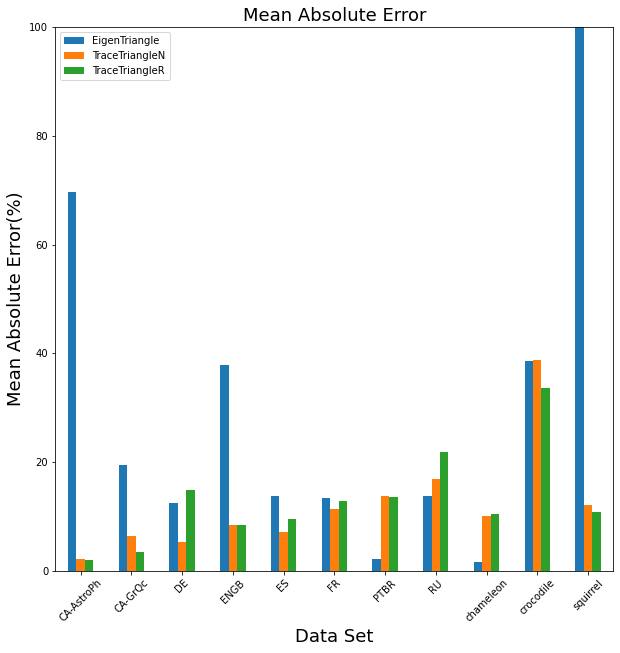

In [229]:
# Create the graph in the same manner as the previous ones.
fig, ax = plt.subplots(1, figsize=(10, 10))
grouped_alg[grouped_alg.alg_name!="SpectralCount"].pivot("ds_path", "alg_name", "abs_error").plot(kind="bar", ax=ax, rot=45, sort_columns=False)

# Set the labels for the graph and save
ax.set_ylabel("Mean Absolute Error(%)")
ax.legend(loc="upper left")
ax.set_xlabel("Data Set")
ax.set_title("Mean Absolute Error")
ax.set_ylim([0,100])
fig.savefig(os.path.join(GRAPH_OUT_PATH, "error_results.png"),facecolor="white")

#### Graphing Mean Absolute Error vs Runtime

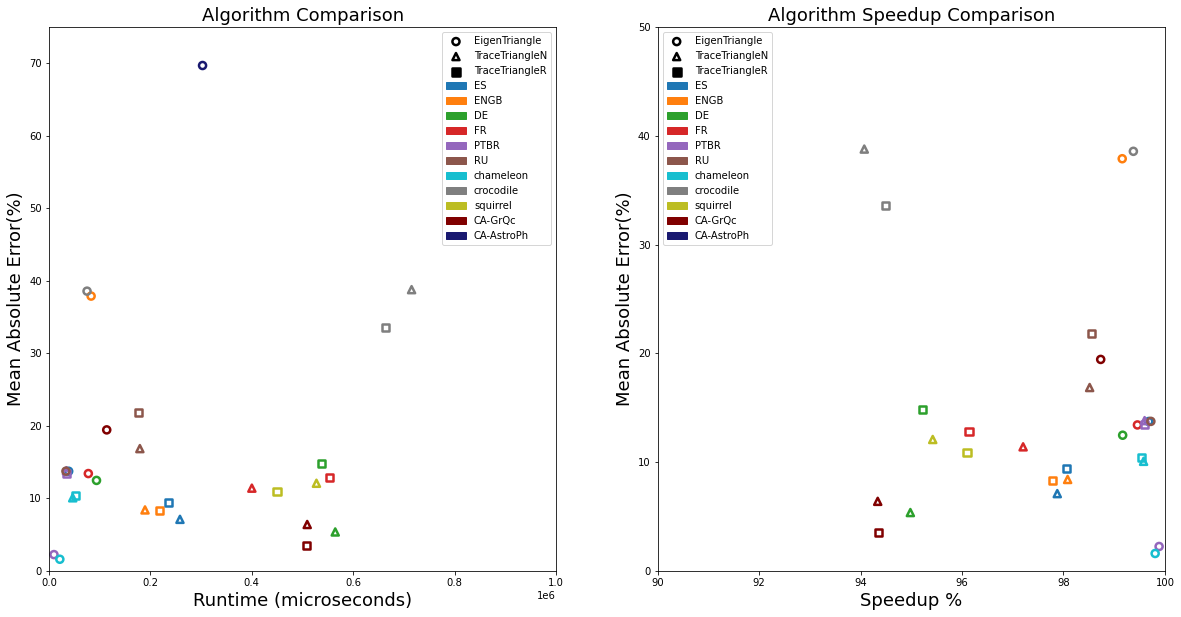

In [239]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

# Spectral Count is the ground truth, so we do not want it to be plotted for Mean absolute Error
# Group by the data set. We do this to graph by color per dataset
for ds_path,ds_group in grouped_alg[grouped_alg.alg_name!="SpectralCount"].groupby("ds_path"):
    
    # Get the current color for the dataset
    color = colors[ds_path]
    
    # Group by the algorithm name so that we can graph each with a specific marker
    for alg_name, alg_group in ds_group.groupby("alg_name"):
            
        # select the marker and set face and edge color accordingly
        marker = "o" if alg_name=="EigenTriangle" else ("s" if alg_name=="TraceTriangleR" else "^")
        facecolor="none"
        edgecolors=color
        
        # Graph the points with the correct marker and colors.
        ax[0].scatter(alg_group["runtime"],alg_group["abs_error"],color=color,marker=marker, facecolor=facecolor,edgecolors=edgecolors,s=50,lw=2.5)
        ax[1].scatter(alg_group["pct_speedup"],alg_group["abs_error"],color=color,marker=marker, facecolor=facecolor,edgecolors=edgecolors,s=50,lw=2.5)

# In order to have a readable legend, we need to manually create the patches
def makeLegendHandlers(ax_index):
    return [
            # ax.scatter retuens an artist for the markers to be used in the legend 
            ax[ax_index].scatter([],[],marker="o",facecolor="none",edgecolor="k",s=50,lw=2.5),
            ax[ax_index].scatter([],[],marker="^",facecolor="none",edgecolor="k",s=50,lw=2.5),
            ax[ax_index].scatter([],[],marker="s",facecolor="k",edgecolor="k",s=50,lw=2.5),
        ]
ax_one_legend= makeLegendHandlers(0)
ax_two_legend= makeLegendHandlers(1)

# Create the labels
legend_labels = [
    "EigenTriangle",
    "TraceTriangleN",
    "TraceTriangleR"
]
# Go through the colors and append the legend 
for ds_path, color in colors.items():
    ax_one_legend.append(Patch(color=color))
    ax_two_legend.append(Patch(color=color))
    legend_labels.append(ds_path)

# Set the axis labels, and save the image.
ax[0].set_ylabel("Mean Absolute Error(%)")
ax[0].set_xlabel("Runtime (microseconds)")
ax[0].set_title("Algorithm Comparison")
ax[0].legend(ax_one_legend,legend_labels)

# Set the labels
ax[1].set_ylabel("Mean Absolute Error(%)")
ax[1].set_xlabel("Speedup %")
ax[1].set_title("Algorithm Speedup Comparison")
ax[1].legend(ax_two_legend,legend_labels)

# Save the figure
fig.savefig(os.path.join(GRAPH_OUT_PATH, "accvsrun.png"),facecolor="white")
ax[0].set_ylim([0,75])
ax[0].set_xlim([0,1e6])
ax[1].set_ylim([0,50])
ax[1].set_xlim([90,100])

fig.savefig(os.path.join(GRAPH_OUT_PATH, "accvsrunZOOOOOOOOOOOOOOOOOM.png"),facecolor="white")

#### Graphing Mean Variance Bars

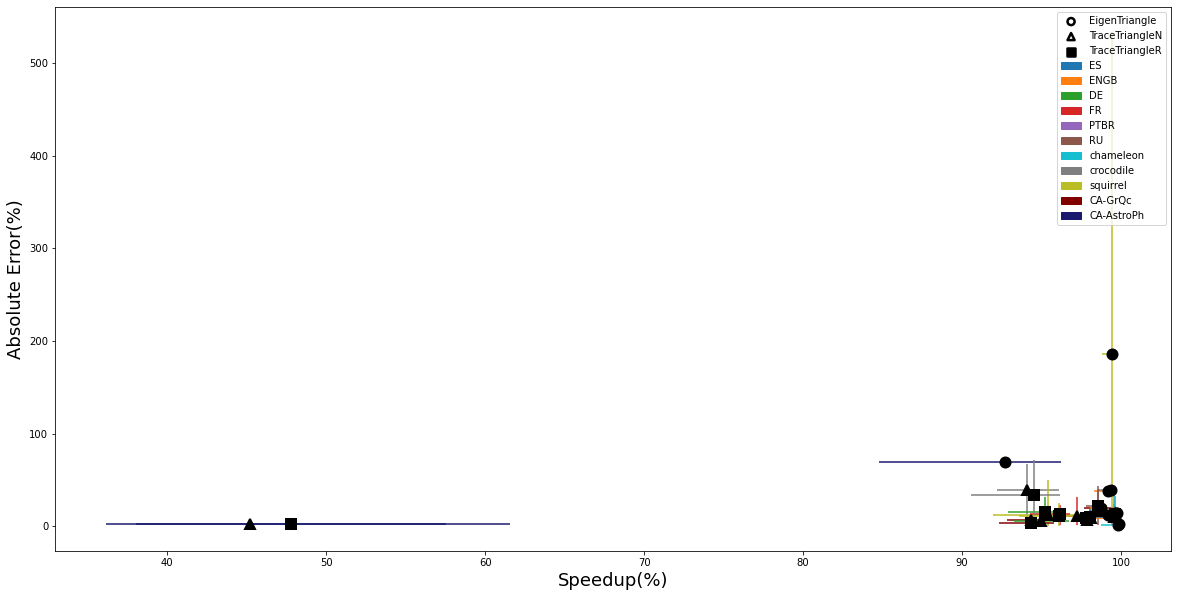

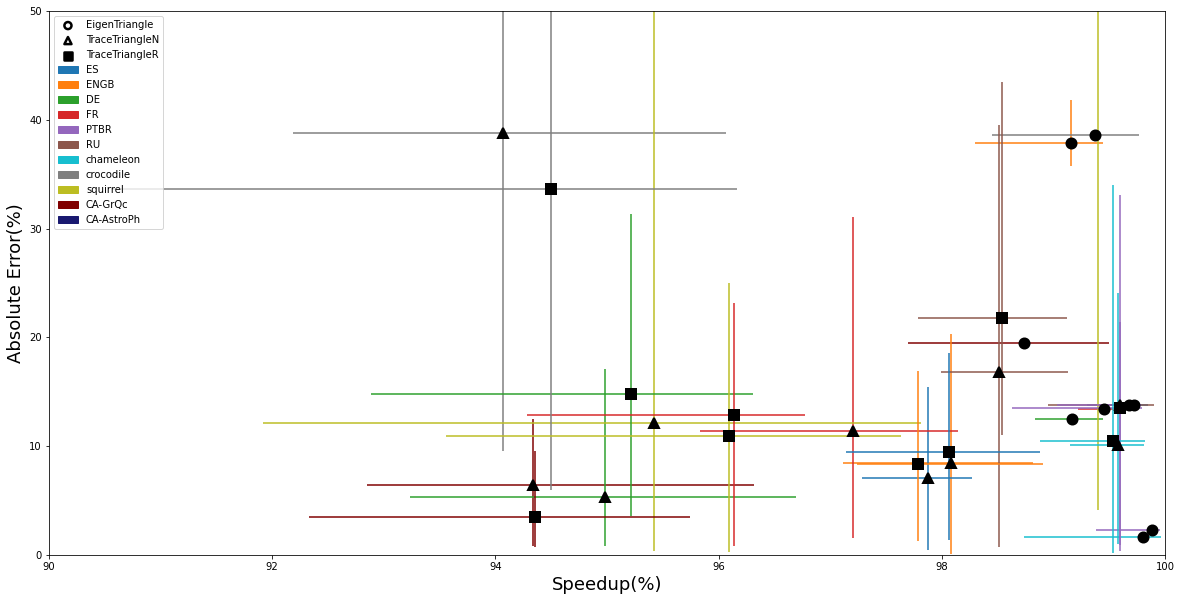

In [234]:
# Group the variance results
var_results = df[df.alg_name!="SpectralCount"].groupby(["alg_name","ds_path"])[["abs_error","pct_speedup","runtime"]]
fig, ax = plt.subplots(1,figsize=(20,10))
fig2, ax2 = plt.subplots(1,figsize=(20,10))

# Helper functions
def getBoxError(data, mean_val):
    return np.array([[mean_val-np.min(data)],[np.max(data)-mean_val]])

# Loop through 
for alg_name,alg_df in var_results:
    # Get the error and calculate the mean
    errors = alg_df["abs_error"]
    mean_errors = np.mean(errors)
    # Get the speedup and calculate the mean
    pct_speedups = alg_df["pct_speedup"]
    mean_speed = np.mean(pct_speedups)
    
    # Set the colors and graph
    e_color = colors[alg_name[1]]
    marker = "o" if alg_name[0]=="EigenTriangle" else ("s" if alg_name[0]=="TraceTriangleR" else "^")
    ax.errorbar(mean_speed,mean_errors,fmt="-k",xerr=getBoxError(pct_speedups,mean_speed),yerr=getBoxError(errors,mean_errors),ecolor=e_color,
                marker=marker,markeredgewidth=2,markersize=10)
    ax2.errorbar(mean_speed,mean_errors,fmt="-k",xerr=getBoxError(pct_speedups,mean_speed),yerr=getBoxError(errors,mean_errors),ecolor=e_color,
                marker=marker,markeredgewidth=2,markersize=10)
    
# Create label for axis and add the legends
ax.set_xlabel("Speedup(%)")
ax.set_ylabel("Absolute Error(%)")
ax.legend(ax_one_legend,legend_labels)
ax2.set_xlabel("Speedup(%)")
ax2.set_ylabel("Absolute Error(%)")
ax2.legend(ax_one_legend,legend_labels)
ax2.set_ylim([0,50])
ax2.set_xlim([90,100])
fig.savefig(os.path.join(GRAPH_OUT_PATH, "varbars.png"),facecolor="white")
fig2.savefig(os.path.join(GRAPH_OUT_PATH, "varbarsZOOOOOOOOOOOM.png"),facecolor="white")